# How weather features impact New York City taxis drivers’ revenue.ipynb

According to [NYC taxi and limousine commission](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), the standard metered taxi fare is composed by:

*   $2.50 initial charge.
*   Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
* Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
* Plus 30 cents Improvement Surcharge.
* Plus 50 cents overnight surcharge 8pm to 6am.
* Plus 1 dolar rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
* Plus New York State Congestion Surcharge of 2.50 dollars (Yellow Taxi) or 2.75 dollars (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
* Plus tips and any tolls.
* There is no charge for extra passengers, luggage or bags, or paying by credit card.

We hypothesized that weather have direct impact on TLC NYC revenue, as weather may impact:

*Total number of rides*
- People may tend to use more/less taxis depends on the weather.

*Fare amount*
- The weather may affect directly the traffic, which will make trips take longer, which will reflect on the fare amount.
- Depends on weather, people may get taxis for longer distances.

*Tip amount*
- People may tend to be more generous when the weather is warmer or sunny
- Due to the weather, the number of passengers per ride may increase, and it can reflect on the tip amount

Considering our hypotheses, we selected from the green tax dataset the columns which may have direct or indirect impact on the ride total amount, being them:

* **Passenger_count**: The number of passengers in the vehicle. This is a driver-entered value.
* **Trip_distance**: The elapsed trip distance in miles reported by the taximeter.
* **Fare_amount**: The time-and-distance fare calculated by the meter.
* **Extra**: Miscellaneous extras and surcharges. Currently, this only includes  the 50 cents and 1 dolar rush hour and overnight charges.
* **MTA_tax**: 50 cents MTA tax that is automatically triggered based on the metered  rate in use.
* **Improvement_surcharge**: 30 cents improvement surcharge assessed on hailed trips at the flag  drop. The improvement surcharge began being levied in 2015.
* **Tip_amount**: This field is automatically populated for credit card  tips. Cash tips are not included.
* **Tolls_amount**: Total amount of all tolls paid in trip. 
* **Total_amount**: The total amount charged to passengers. Does not include cash tips.

Green taxi trip records data dictionary of LPEP Trip Records can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

Considering the dataset dictionary and the taxi fare calculation rules, we can say that:
```
Total_amount = Fare_amount + Extra + MTA_tax + Tip_amount + Tolls_amount
```

This analysis will establish the correlation between:
* Weather x number of rides
* Weather x fare amount
* Weather x tip amount


#Code preparation

Mount Google drive, which stores the dataset.

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/My Drive/')

!ls

Mounted at /content/drive/
'CA660 Statistical Data Analysis'
 CA683_Data_Analytics_Data_Mining
 CA684_Assignment
 CA684_Machine_Learning
 count_plot.png
 inceptionV3_first_frame.csv
 Loading_Features.ipynb
 Memorability
'Mooc 1'
'Mooc 2'
'Mooc 3'
'Mooc 3 (1)'
'MOOC 4'
'More Examples.gdoc'
'More Examples.pdf'
'More Examples Q3 Q4.gdoc'
'More Examples Q3 Q4.pdf'
 my_model.h5
 Predicting_Memorability.ipynb
 Predicting_Memorability_using_video-captions.ipynb


Importing libraries which will be used.

In [5]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
import tensorflow
from collections import Counter
from pathlib import Path
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from tensorflow.python.keras.preprocessing.text import Tokenizer

seed(1)
tensorflow.random.set_seed(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data from source

It will load green tax trip and weather data from google drive. 

The files were imported from [Green trip data source](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [6]:
data_path = './CA683_Data_Analytics_Data_Mining/Assignment/'

In [ ]:
def read_green_trip_dataset(file_name):
  # Specifies header of green trip dataset files
  header_name = ['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type']
  # Define columns which will be used for the analyses from green tax dataset
  columns = ['lpep_pickup_datetime', 'RateCodeID', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'improvement_surcharge', 'Total_amount']
  df = pd.read_csv(file_name, header=None, names=header_name, usecols=columns, low_memory=False)
  # Drops first line, as it is the file header, which is being ignored.
  return df[1:];

greentax_data_path = data_path+'GreenTripDataset2015/'
df_green_tripdata_jan_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-01.csv')
df_green_tripdata_fev_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-02.csv')
df_green_tripdata_mar_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-03.csv')
df_green_tripdata_apr_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-04.csv')
df_green_tripdata_may_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-05.csv')
df_green_tripdata_jun_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-06.csv')
df_green_tripdata_jul_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-07.csv')
df_green_tripdata_aug_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-08.csv')
df_green_tripdata_sep_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-09.csv')
df_green_tripdata_oct_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-10.csv')
df_green_tripdata_nov_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-11.csv')
df_green_tripdata_dec_2015 = read_green_trip_dataset(greentax_data_path+'green_tripdata_2015-12.csv')

The weather dataset was imported from [Iowa Environmental Mesonet (IEM)](https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#d)


In [ ]:
def read_weather_dataset(file_name):
  #specifies header for weather data set
  header_names = ['station','date_time', 'temperature', 'dew_point', 'relative_humidity', 'wind_direction', 'wind_speed','precipitation',
                  'pressure_altimeter','sea_level_pressure', 'visibility', 'wind_gust','sky_level_1_coverage', 'sky_level_2_coverage',
                  'sky_level_3_coverage','sky_level_4_coverage','sky_level_1_altitute', 'sky_level_2_altitude','sky_level_3_altitude',
                  'sky_level_4_altitude','weather_codes','ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr','peak_wind_gust',
                  'peak_wind_direction','peak_wind_time','feel_temperature', 'metar']

              
  columns = ['date_time', 'temperature', 'dew_point', 'relative_humidity', 'wind_direction', 'wind_speed','precipitation',
             'pressure_altimeter','sea_level_pressure', 'visibility', 'wind_gust','sky_level_1_coverage', 'sky_level_2_coverage',
             'sky_level_3_coverage','sky_level_4_coverage','sky_level_1_altitute', 'sky_level_2_altitude','sky_level_3_altitude',
             'sky_level_4_altitude','weather_codes','feel_temperature']

  df = pd.read_csv(file_name, header=None, names=header_names, usecols= columns, low_memory=False)
  #Drops first line, as it is the file header, which is being ignored
  df = df[1:]
  #Returns df
  return df;
  
df_weather = read_weather_dataset(data_path + 'nyc_hourly_weather.csv')
df_weather

,date_time,temperature,dew_point,relative_humidity,wind_direction,wind_speed,precipitation,pressure_altimeter,sea_level_pressure,visibility,wind_gust,sky_level_1_coverage,sky_level_2_coverage,sky_level_3_coverage,sky_level_4_coverage,sky_level_1_altitute,sky_level_2_altitude,sky_level_3_altitude,sky_level_4_altitude,weather_codes,feel_temperature
1,2015-01-01 00:51,30.02,6.98,37.17,260.00,4.00,0.00,30.25,1023.50,10.00,M,CLR,M,M,M,M,M,M,M,M,25.11
2,2015-01-01 01:51,30.02,6.08,35.68,240.00,3.00,0.00,30.23,1023.00,10.00,M,CLR,M,M,M,M,M,M,M,M,26.43
3,2015-01-01 02:51,30.02,8.06,39.03,M,4.00,0.00,30.21,1022.30,10.00,M,CLR,M,M,M,M,M,M,M,M,25.11
4,2015-01-01 03:51,28.94,8.96,M,M,M,0.00,30.20,1022.00,10.00,M,CLR,M,M,M,M,M,M,M,M,M
5,2015-01-01 04:51,28.04,8.96,44.07,M,4.00,0.00,30.20,1021.80,10.00,M,CLR,M,M,M,M,M,M,M,M,22.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,2015-12-30 20:51,44.06,39.92,85.25,60.00,6.00,0.00,30.24,1023.20,4.00,M,OVC,M,M,M,700.00,M,M,M,BR,40.05
10642,2015-12-30 21:32,44.96,39.92,82.38,60.00,4.00,0.00,30.24,M,7.00,M,OVC,M,M,M,1100.00,M,M,M,M,42.55
10643,2015-12-30 21:51,44.96,39.92,82.38,60.00,4.00,0.00,30.23,1022.90,7.00,M,OVC,M,M,M,1200.00,M,M,M,M,42.55
10644,2015-12-30 22:51,44.96,39.92,82.38,100.00,7.00,0.00,30.20,1021.90,8.00,M,OVC,M,M,M,1200.00,M,M,M,M,40.58


# Analyzing green tax trips dataset

## Sampling green tax data

As the green tax trip records dataset is splitted in months (one file for each month), we need to validate how many rows there are in total for the year of 2015.


Total trips in 2015: 19233765


Text(0, 0.5, 'Trip counts')

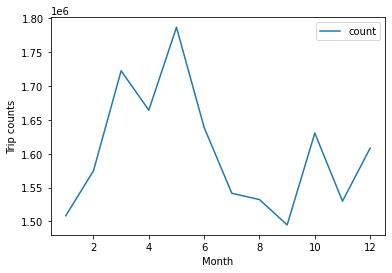

In [ ]:
green_tripdata_count_summary = []
green_tripdata_count_summary.append((1, len(df_green_tripdata_jan_2015))) 
green_tripdata_count_summary.append((2, len(df_green_tripdata_fev_2015))) 
green_tripdata_count_summary.append((3, len(df_green_tripdata_mar_2015))) 
green_tripdata_count_summary.append((4, len(df_green_tripdata_apr_2015))) 
green_tripdata_count_summary.append((5, len(df_green_tripdata_may_2015))) 
green_tripdata_count_summary.append((6, len(df_green_tripdata_jun_2015))) 
green_tripdata_count_summary.append((7, len(df_green_tripdata_jul_2015))) 
green_tripdata_count_summary.append((8, len(df_green_tripdata_aug_2015))) 
green_tripdata_count_summary.append((9, len(df_green_tripdata_sep_2015))) 
green_tripdata_count_summary.append((10, len(df_green_tripdata_oct_2015))) 
green_tripdata_count_summary.append((11, len(df_green_tripdata_nov_2015))) 
green_tripdata_count_summary.append((12, len(df_green_tripdata_dec_2015))) 

df_green_tripdata_count_summary = pd.DataFrame(green_tripdata_count_summary, columns=['month', 'count'])

total_green_trips = df_green_tripdata_count_summary["count"].sum();
print("Total trips in 2015: {}".format(total_green_trips))
green_tripdata_count_summary_plot = df_green_tripdata_count_summary.plot(x="month", y="count")
green_tripdata_count_summary_plot.set_xlabel("Month")
green_tripdata_count_summary_plot.set_ylabel("Trip counts")

Due to big volume of data, we decided to genererate data samples for each month, and merge all months data sample together, so we can have an unique dataset with 2015 sample data of green tax trip records.

In [ ]:
def convert_not_sampled_green_trip_dataset_columns_type(df):
  df['Tip_amount'] = pd.to_numeric(df['Tip_amount'])
  df['Fare_amount'] = pd.to_numeric(df['Fare_amount'])
  return df

def generate_sample_df(df):
  sample_seed = 43
  sample_pct = 0.10
  # This analysis will focus just on the standard rate
  df = convert_not_sampled_green_trip_dataset_columns_type(df)
  df = df.sample(frac = sample_pct, random_state = sample_seed) 
  return df;

df_green_tripdata_sample_jan_2015 = generate_sample_df(df_green_tripdata_jan_2015)
df_green_tripdata_sample_fev_2015 = generate_sample_df(df_green_tripdata_fev_2015) 
df_green_tripdata_sample_mar_2015 = generate_sample_df(df_green_tripdata_mar_2015)
df_green_tripdata_sample_apr_2015 = generate_sample_df(df_green_tripdata_apr_2015)
df_green_tripdata_sample_may_2015 = generate_sample_df(df_green_tripdata_may_2015)
df_green_tripdata_sample_jun_2015 = generate_sample_df(df_green_tripdata_jun_2015)
df_green_tripdata_sample_jul_2015 = generate_sample_df(df_green_tripdata_jul_2015)
df_green_tripdata_sample_aug_2015 = generate_sample_df(df_green_tripdata_aug_2015)
df_green_tripdata_sample_sep_2015 = generate_sample_df(df_green_tripdata_sep_2015)
df_green_tripdata_sample_oct_2015 = generate_sample_df(df_green_tripdata_oct_2015)
df_green_tripdata_sample_nov_2015 = generate_sample_df(df_green_tripdata_nov_2015)
df_green_tripdata_sample_dec_2015 = generate_sample_df(df_green_tripdata_dec_2015)

df_green_tripdata_sample_2015 = pd.concat([df_green_tripdata_sample_jan_2015, df_green_tripdata_sample_fev_2015, df_green_tripdata_sample_mar_2015, df_green_tripdata_sample_apr_2015, df_green_tripdata_sample_may_2015, df_green_tripdata_sample_jun_2015, df_green_tripdata_sample_jul_2015, df_green_tripdata_sample_aug_2015, df_green_tripdata_sample_sep_2015, df_green_tripdata_sample_oct_2015, df_green_tripdata_sample_nov_2015, df_green_tripdata_sample_dec_2015])

Now that we have the sample data of green taxs trip record for the year of 2015, we will merge the sample, in one unique dataframe

Total sample trips in 2015: 1923376


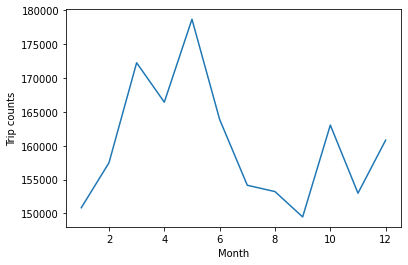

In [ ]:
def convert_green_trip_dataset_columns_type(df):
  df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%Y-%m-%d', errors='coerce')
  df['Passenger_count'] = pd.to_numeric(df['Passenger_count'])
  df['Trip_distance'] = pd.to_numeric(df['Trip_distance'])
  df['Fare_amount'] = pd.to_numeric(df['Fare_amount'])
  df['Extra'] = pd.to_numeric(df['Extra'])
  df['MTA_tax'] = pd.to_numeric(df['MTA_tax'])
  df['Tip_amount'] = pd.to_numeric(df['Tip_amount'])
  df['improvement_surcharge'] = pd.to_numeric(df['improvement_surcharge'])
  df['Total_amount'] = pd.to_numeric(df['Total_amount'])
  return df

df_green_tripdata_sample_2015 = convert_green_trip_dataset_columns_type(df_green_tripdata_sample_2015)
df_green_tripdata_sample_2015_count_summary =  df_green_tripdata_sample_2015['lpep_pickup_datetime'].groupby(by=[df_green_tripdata_sample_2015['lpep_pickup_datetime'].dt.month]).agg('count')
df_green_tripdata_sample_2015_plot  = df_green_tripdata_sample_2015_count_summary.plot()
df_green_tripdata_sample_2015_plot.set_xlabel("Month")
df_green_tripdata_sample_2015_plot.set_ylabel("Trip counts")

total_sample_green_trips = df_green_tripdata_sample_2015_count_summary.sum();
print("Total sample trips in 2015: {}".format(total_sample_green_trips))

As the data frame with the sample data of the whole year of 2015 was generated, we can delete the data frame with the full and  sampled data of the individual months. It will realease the used memory and will avoid the session to crash inexpectly.

In [ ]:
del [df_green_tripdata_jan_2015, df_green_tripdata_fev_2015, df_green_tripdata_mar_2015, df_green_tripdata_apr_2015, df_green_tripdata_may_2015, df_green_tripdata_jun_2015, df_green_tripdata_jul_2015, df_green_tripdata_aug_2015, df_green_tripdata_sep_2015, df_green_tripdata_oct_2015, df_green_tripdata_nov_2015, df_green_tripdata_dec_2015]
del [df_green_tripdata_sample_jan_2015, df_green_tripdata_sample_fev_2015, df_green_tripdata_sample_mar_2015, df_green_tripdata_sample_apr_2015, df_green_tripdata_sample_may_2015, df_green_tripdata_sample_jun_2015, df_green_tripdata_sample_jul_2015, df_green_tripdata_sample_aug_2015, df_green_tripdata_sample_sep_2015, df_green_tripdata_sample_oct_2015, df_green_tripdata_sample_nov_2015, df_green_tripdata_sample_dec_2015]
gc.collect()

54

Identifying outliers on the sample dataset, as it will impact the analysis

Passenger_count                      ... Total_amount                
                               count      mean       std  ...          50%    75%      max
lpep_pickup_datetime                                      ...                             
1                           150850.0  1.386583  1.073158  ...        10.80  17.00   900.30
2                           157483.0  1.379616  1.060107  ...        11.30  17.30   547.30
3                           172257.0  1.377024  1.055665  ...        11.30  17.30  3789.30
4                           166439.0  1.375158  1.051481  ...        11.30  17.80  4035.46
5                           178685.0  1.381101  1.056631  ...        11.80  18.30   700.00
6                           163887.0  1.372446  1.042046  ...        11.30  17.80  1229.80
7                           154167.0  1.375988  1.050033  ...        11.30  17.80   856.09
8                           153234.0  1.383211  1.061144  ...        11.76  18.00  1372.55
9                           149493.0  1.370867  1.039028  ...        11.76  18.30   480.00
10                          163054.0  1.366253  1.034236  ...        11.44  17.88   450.00
11                          152998.0  1.363332  1.030556  ...        11.30  17.80   495.00
12                          160829.0  1.360215  1.026409  ...        11.30  17.64   499.00

[12 rows x 64 columns]

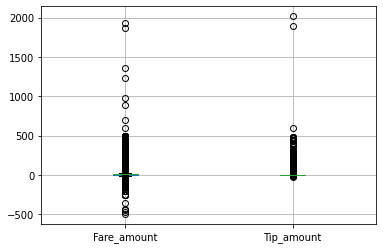

In [ ]:
df_green_tripdata_sample_2015.boxplot(column=["Fare_amount", "Tip_amount"])
df_green_tripdata_sample_2015.groupby(by=[df_green_tripdata_sample_2015['lpep_pickup_datetime'].dt.month]).describe()

Passenger_count                      ... Total_amount              
                               count      mean       std  ...          50%    75%    max
lpep_pickup_datetime                                      ...                           
1                           150354.0  1.386362  1.072985  ...        10.80  17.00  79.55
2                           156931.0  1.379485  1.060273  ...        11.20  17.30  79.63
3                           171632.0  1.377121  1.056349  ...        11.30  17.30  79.80
4                           165804.0  1.374828  1.051605  ...        11.30  17.80  79.88
5                           177969.0  1.381123  1.057007  ...        11.80  18.30  79.88
6                           163186.0  1.372238  1.042448  ...        11.30  17.80  79.85
7                           153609.0  1.375785  1.049849  ...        11.30  17.80  79.85
8                           152625.0  1.382860  1.060932  ...        11.76  17.88  79.84
9                           148962.0  1.370772  1.039046  ...        11.76  18.30  79.84
10                          162416.0  1.365777  1.033634  ...        11.44  17.85  79.84
11                          152410.0  1.362732  1.029777  ...        11.30  17.76  79.88
12                          160064.0  1.359706  1.026137  ...        11.30  17.30  79.80

[12 rows x 64 columns]

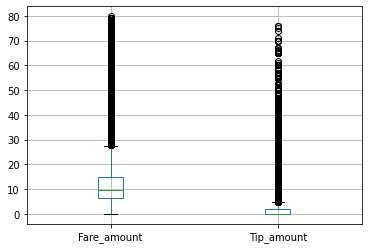

In [ ]:
df_green_tripdata_sample_2015 = df_green_tripdata_sample_2015[(df_green_tripdata_sample_2015["Fare_amount"] >= 0)&(df_green_tripdata_sample_2015["Tip_amount"] >= 0)]
# First quartile value
q1 = df_green_tripdata_sample_2015['Total_amount'].quantile(0.05)
# Third quartile value
q3 = df_green_tripdata_sample_2015['Total_amount'].quantile(0.95)
# Interquartile range
iqr = q3-q1
# Acceptable range
low  = q1-1.5*iqr
high = q3+1.5*iqr

df_green_tripdata_sample_2015 = df_green_tripdata_sample_2015.loc[(df_green_tripdata_sample_2015['Total_amount'] >= low) & (df_green_tripdata_sample_2015['Total_amount'] <= high)]
df_green_tripdata_sample_2015.boxplot(column=["Fare_amount", "Tip_amount"])
df_green_tripdata_sample_2015.groupby(by=[df_green_tripdata_sample_2015['lpep_pickup_datetime'].dt.month]).describe()

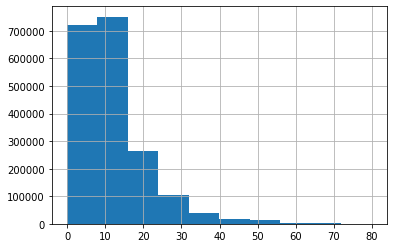

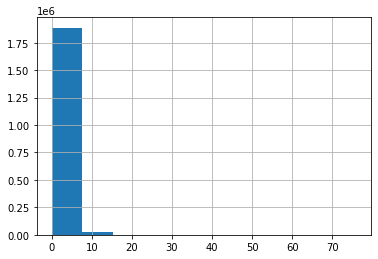

In [ ]:
df_green_tripdata_sample_2015["Fare_amount"].hist()
plt.show()
df_green_tripdata_sample_2015["Tip_amount"].hist()
plt.show()

## Plotting green tax data and analyzing collinearity

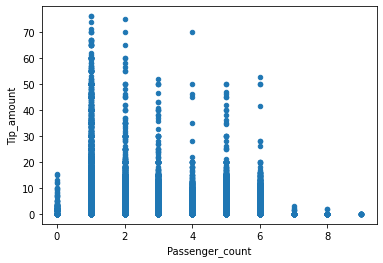

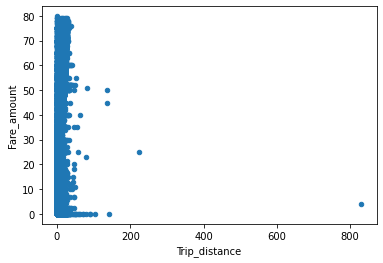

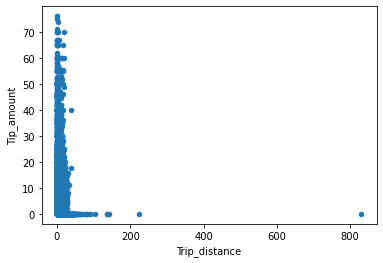

In [ ]:
df_green_tripdata_sample_2015.plot.scatter(x='Passenger_count', y='Tip_amount')
df_green_tripdata_sample_2015.plot.scatter(x='Trip_distance', y='Fare_amount')
df_green_tripdata_sample_2015.plot.scatter(x='Trip_distance', y='Tip_amount')

In [ ]:
corr = df_green_tripdata_sample_2015[['Tip_amount','Passenger_count','Trip_distance', 'Fare_amount']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Tip_amount,Passenger_count,Trip_distance,Fare_amount
Tip_amount,1.000000,0.007176,0.406219,0.426174
Passenger_count,0.007176,1.000000,0.011380,0.012651
Trip_distance,0.406219,0.011380,1.000000,0.881816
Fare_amount,0.426174,0.012651,0.881816,1.000000


As it is possible to observe on the results, the fare amount and the trip distance are highly correlated, hence we can drop the trip distance value.

In [ ]:
formula_str="Fare_amount~Trip_distance"
result_trip_distance_fare_amount = sm.ols(formula=formula_str,data=df_green_tripdata_sample_2015).fit()
print(result_trip_distance_fare_amount.summary())

                            OLS Regression Results                            
Dep. Variable:            Fare_amount   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                 6.699e+06
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:34:38   Log-Likelihood:            -5.4104e+06
No. Observations:             1915962   AIC:                         1.082e+07
Df Residuals:                 1915960   BIC:                         1.082e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.5891      0.004   1106.279

As it is possible to observe on the results, the correlation between tips among and trip distance are not significant.

In [ ]:
formula_str="Tip_amount~Trip_distance"
result_trip_distance_tip_amount = sm.ols(formula=formula_str,data=df_green_tripdata_sample_2015).fit()
print(result_trip_distance_tip_amount.summary())

                            OLS Regression Results                            
Dep. Variable:             Tip_amount   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                 3.786e+05
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:34:39   Log-Likelihood:            -3.9592e+06
No. Observations:             1915962   AIC:                         7.918e+06
Df Residuals:                 1915960   BIC:                         7.918e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3271      0.002    168.195

As it is possible to observe on the results, there is no correlation between the number of passengers and the tip amount, hence he can drop the hypothesis that the number of passengers per reflects on the tip amount 

In [ ]:
formula_str="Tip_amount~Passenger_count"
result_passenger_count_tip_amount = sm.ols(formula=formula_str,data=df_green_tripdata_sample_2015).fit()
print(result_passenger_count_tip_amount.summary())

                            OLS Regression Results                            
Dep. Variable:             Tip_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     98.67
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           2.98e-23
Time:                        17:34:40   Log-Likelihood:            -4.1319e+06
No. Observations:             1915962   AIC:                         8.264e+06
Df Residuals:                 1915960   BIC:                         8.264e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1506      0.002    4

Considering on our hypotheses and the correlation results, we need to calculate per hour:
* Total number of rides
* Total fare amount
* Total amount of tips 

In [ ]:
df_green_tripdata_2015_agg_per_hour = df_green_tripdata_sample_2015.groupby(by=df_green_tripdata_sample_2015['lpep_pickup_datetime'].dt.to_period('H')).agg({"Fare_amount": ['count', 'sum'], "Tip_amount": ['count', 'sum']})
df_green_tripdata_2015_agg_per_hour.columns = df_green_tripdata_2015_agg_per_hour.columns.map('_'.join)
df_green_tripdata_2015_agg_per_hour = df_green_tripdata_2015_agg_per_hour.reset_index()
df_green_tripdata_2015_agg_per_hour


,lpep_pickup_datetime,Fare_amount_count,Fare_amount_sum,Tip_amount_count,Tip_amount_sum
0,2015-01-01 00:00,625,7931.50,625,647.52
1,2015-01-01 01:00,676,8987.00,676,679.02
2,2015-01-01 02:00,631,8982.50,631,726.00
3,2015-01-01 03:00,611,7931.01,611,641.07
4,2015-01-01 04:00,568,7193.50,568,531.70
...,...,...,...,...,...
8752,2015-12-31 19:00,540,6070.50,540,562.65
8753,2015-12-31 20:00,565,6677.05,565,690.48
8754,2015-12-31 21:00,625,8029.50,625,765.40
8755,2015-12-31 22:00,658,8057.50,658,706.39


# Analyzing weather data

## Exploring the dataset 
Getting a summary to understand the weather data we have

In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10645 entries, 1 to 10645
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             10645 non-null  object
 1   temperature           10645 non-null  object
 2   dew_point             10645 non-null  object
 3   relative_humidity     10645 non-null  object
 4   wind_direction        10645 non-null  object
 5   wind_speed            10645 non-null  object
 6   precipitation         10645 non-null  object
 7   pressure_altimeter    10645 non-null  object
 8   sea_level_pressure    10645 non-null  object
 9   visibility            10645 non-null  object
 10  wind_gust             10645 non-null  object
 11  sky_level_1_coverage  10645 non-null  object
 12  sky_level_2_coverage  10645 non-null  object
 13  sky_level_3_coverage  10645 non-null  object
 14  sky_level_4_coverage  10645 non-null  object
 15  sky_level_1_altitute  10645 non-null

We observe 10645 rows with the no column containing null values. Let us take a sample to explore the data more in detail. 

In [ ]:
pd.set_option('display.max_columns', None)
df_sample = df_weather.sample(frac = 0.001, random_state = 61) 
df_sample

We observe an "M" value in several columnns. "M" in standard [METAR](https://en.wikipedia.org/wiki/METAR) notation refers to "minus/less than" however, in this dataset, "M" refers to "missing", "not available", or "not observed" [data](https://www.weather.gov/media/asos/aum-toc.pdf).

Let us validate how extensive the presence of non-numeric values in numeric columns is in the full data set. In this way, we will know how to process the data adequately.

In [ ]:
#Printing how many rows in with non-numeric values in "precipitation" we have
print('Rows in the complete set that contain non-numeric values in column "precipitation"') 
df_weather[pd.to_numeric(df_weather['precipitation'], errors='coerce').isnull()]

We also observe almost 500 rows with non-numeric values in Temperature. 

Let's also take a look at the "weather codes" column, which seems to contain a collection of values. 

In [ ]:
#Printing the different unique values in the column "weather_codes"
array = df_weather['weather_codes'].unique()
metar_codes = []
for i in array: 
  events = i.split(" ")
  for j in events:
    metar_codes.append(j)
pd.DataFrame(metar_codes)[0].unique()


## Cleaning dataset

From looking at the DataFrame info, the sampled date, and the data in categorical and numeric (continuous) columns, we conclude a few things:

* The weather data is provided by day and hour of the day (taken at the 51 minutes of the hour). We will transform this column from string to date_time, will filter the data to dates in the year 2015, and use the column as index for easier data-handling.

* Both categorical and continuous columns contain the value "M". For columns with categorical values, we will consider "M" as a "not observed" category. For columns with continuous values, we will consider  "M" as "missing data", and apply data imputation (https://en.wikipedia.org/wiki/Imputation_(statistics), http://www.stat.columbia.edu/~gelman/arm/missing.pdf) to get values that we can use in the model. There are multiple techniques for data imputation or dealing with missing values (e.g. nearest neighbor method, averaging forward and back-fill values, or interpolation).

* The column "precipication" contains a "T" value in many rows. "T" stands for "traces" and is used by meteorologists when the amount of precipitation is < 0.1 inch. While the existence of traces is recorded for historic purposes, it is considered considered negligible for most weather models. For this exercise, we will convert "T" to 0.   

* The column "weather_codes" contains a collection of weather events identified by METAR codes (https://www.weather.gov/media/wrh/mesowest/metar_decode_key.pdf), separated by spaces and, according to what DataFrame.info() showed, no null values. We will process this column into separate columns for each weather event (snow, thunderstorm, rain, fog) on the day, and assign each with a boolean value depending on their occurrence on that day. 

* The numeric values for all columns (except "sky_level_N_code", see below), might be actually strings. We will convert them to numbers. 

* The columns "sky_level_N_cover", which indicates how cloudy the sky is, is using an "oktas" scale (https://en.wikipedia.org/wiki/Okta). However, it seems to be indicating the 9th level ("sky obscured from view") with a null, rather than a 9. We will replace the null with the corresponding '9' value and then proceed to convert it to numbers. NB: This is a discrete/categorical column. 


In [ ]:
from sklearn.impute import KNNImputer 

#Handles missing data in a column using the selected method
def process_continuous_data(df, column_name, missing_data_method):
  df[column_name] = pd.to_numeric(df[column_name], errors= 'coerce')
  if missing_data_method == 'linear_interpolation': 
    df[column_name].interpolate(method='linear', inplace=True) 
  else:
    if missing_data_method == 'back_forward_average':
      df['relative_humidity'] = (df.relative_humidity.ffill()+df.relative_humidity.bfill())/2
    else:
      if missing_data_method == '5_n_neighbor':
        imputer = KNNImputer(n_neighbors=5,  weights='uniform') 
        df['relative_humidity']= imputer.fit_transform(df[['relative_humidity']]).ravel()
      else:
        if missing_data_method != None:
          print("Handling method specific is not valid")

def refine_weather_data(df, start_date, end_date):
  #Transforms date to datetime format and other columns into numbers
  df['date_time'] = pd.to_datetime(df['date_time'],format= '%Y-%m-%d %H:%M')
  df =df.loc[(df['date_time'] >= start_date) & (df['date_time'] <= end_date)]
 

  #Transforming columns with continuous values to numbers
  process_continuous_data(df,'temperature', 'linear_interpolation')
  process_continuous_data(df,'dew_point', 'linear_interpolation')
  process_continuous_data(df,'relative_humidity', 'linear_interpolation')
  #process_continuous_data(df,'wind_speed', 'linear_interpolation')
  process_continuous_data(df,'precipitation', 'linear_interpolation')
  #process_continuous_data(df,'pressure_altimeter', 'linear_interpolation')
  #process_continuous_data(df,'sea_level_pressure', 'linear_interpolation')
  process_continuous_data(df,'visibility', 'linear_interpolation')
  #process_continuous_data(df,'wind_gust', 'linear_interpolation')
  #process_continuous_data(df,'sky_level_1_altitute', 'linear_interpolation')
  #process_continuous_data(df,'sky_level_2_altitude', 'linear_interpolation')
  #process_continuous_data(df,'sky_level_3_altitude', 'linear_interpolation')
  #process_continuous_data(df,'sky_level_4_altitude', 'linear_interpolation')
  process_continuous_data(df,'feel_temperature', 'linear_interpolation')

  #Determines the occurrence and intensity of events in an METAR weather code
  def decode_metar(events, metar_code):
    
    intensity = "NONE" #event did not occur

    for event in events:
      if metar_code in event:
        if '-' in event:
          intensity = "LIGHT" #1 light intensity
          #print("light stuff")
        else:
          if '+' in event:
            intensity =  "HEAVY" #3 heavy intensity
          else:
            intensity = "MODERATE" #2 moderate intensity
        break;
    
    return intensity

  #Processes each weather_code row
  def get_events(row, mist_events, snow_events, haze_events, rain_events, unknown_precipitation_events, fog_events):
    if (isinstance(row.weather_codes, str)):
      events = row.weather_codes.upper().split(" ")
    else:
      events = ['']

    #Metar codes: 
    #BR= mist
    #SN: snow
    #HZ: haze
    #RA: rain
    #UP: unknown precipitation
    #FG: fog
    mist_events.append(decode_metar(events, 'BR'))
    snow_events.append(decode_metar(events, 'SN'))
    haze_events.append(decode_metar(events, 'HZ'))
    rain_events.append(decode_metar(events, 'RA'))
    unknown_precipitation_events.append(decode_metar(events, 'UP'))
    fog_events.append(decode_metar(events, 'FG'))

  #Defines temporary arrays to store each weather event occurrence
  mist_events = []
  snow_events = []
  haze_events = []
  rain_events = []
  unknown_precipitation_events = []
  fog_events = []
  #Splits 'weather_events' column into columns for each weather event
  df.apply(lambda x: get_events(x, mist_events, snow_events, haze_events, rain_events, unknown_precipitation_events, fog_events), axis = 1)
  #Assigns results to dedicated columns
  df = df.assign(mist = mist_events, snow = snow_events, haze = haze_events, rain = rain_events, unknown_precipitation= unknown_precipitation_events, fog= fog_events)
  #Drops unnecessary 'events' column
  df.drop(['weather_codes'], axis=1, inplace=True)

  #Has repeated hours (it considers category combinations)
  df = df.groupby(by=[df['date_time'].dt.to_period('H'), df["rain"],df["mist"], df["snow"],df["haze"],df["unknown_precipitation"]]).mean()
  df = df.reset_index()
 
  #Setting date_time as index 
  df.set_index('date_time', inplace = True)
  
  df_repeated = df.groupby(by=[df.index]).count()
  df_repeated = df_repeated.loc[df_repeated["temperature"]> 1]
 
  def get_higher_priority(df_t, prop):
    if len(df_t.loc[df_t[prop] == "HEAVY"]) > 0:
      return "HEAVY"
    if len(df_t.loc[df_t[prop] == "LIGHT"]) > 0:
      return "LIGHT"
    if len(df_t.loc[df_t[prop] == "MODERATE"]) > 0:
      return "MODERATE"
    if len(df_t.loc[df_t[prop] == "EXIST"]) > 0:
      return "EXISTS"
    return "NONE"

  def get_higher_priority_n(df_t, prop):
    if len(df_t.loc[df_t[prop] == 3]) > 0:
      return 3
    if len(df_t.loc[df_t[prop] == 1]) > 0:
      return 1
    if len(df_t.loc[df_t[prop] == 2]) > 0:
      return 2
    return 0


  for row in df_repeated.iloc:

    df_repeated_rows = df.loc[df.index ==row.name]
    rain = get_higher_priority(df_repeated_rows, "rain")
    mist = get_higher_priority(df_repeated_rows, "mist")
    snow = get_higher_priority(df_repeated_rows, "snow")
    haze = get_higher_priority(df_repeated_rows, "haze")
    unknown_precipitation = get_higher_priority(df_repeated_rows,"unknown_precipitation")
    row_to_keep = df.loc[df.index == row.name].head(1);
    
    df.drop(row.name, axis=0, inplace=True)
    row_to_keep["rain"] = rain
    row_to_keep["mist"] = mist
    row_to_keep["snow"] = snow
    row_to_keep["haze"] = haze
    row_to_keep["unknown_precipitation"] = unknown_precipitation
    df = df.append(row_to_keep)
          
  return df

df_weather_2015 = refine_weather_data(df_weather, '1/1/2015 00:00', '12/31/2015 23:59')
df_weather_2015

#df_weather_2015.loc[(df_weather_2015.index.day == 3) & (df_weather_2015.index.month == 1)]




#df = df_weather_2015.groupby(by=[df_weather_2015.index]).count()
#df = df.loc[df["temperature"]> 1]
#df


  




Now we should have no rows with non-numeric or null values for "cloud cover" or "precipitation".

In [ ]:
#Printing how many rows in with non-numeric values in "precipitation" we have
print('Number of rows in the complete set that contain non-numeric values in column "precipitation"')
print(df_weather_2015[pd.to_numeric(df_weather_2015['precipitation'], errors='coerce').isnull()])



## Plotting weather features and analyzing collinearity

Plotting some weathers features, over time to understand how they evolve

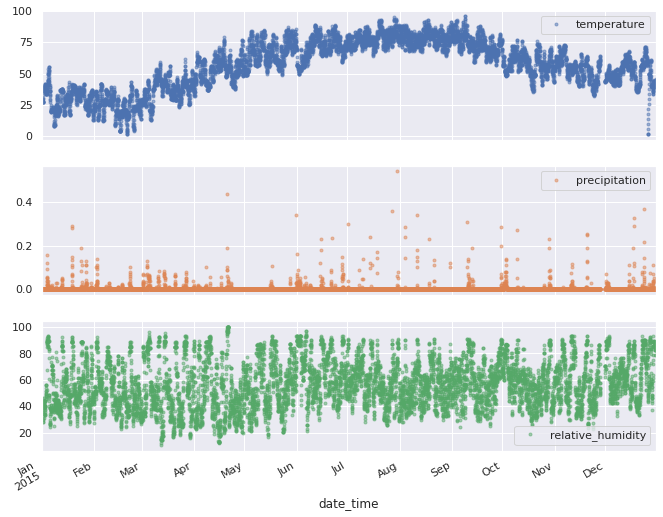

In [ ]:
#Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

#Plotting temperatures over the whole year
columns_plot = ['temperature', 'precipitation', 'relative_humidity']
axes = df_weather_2015[columns_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#axes[0].set_ylabel('Temperature in F')




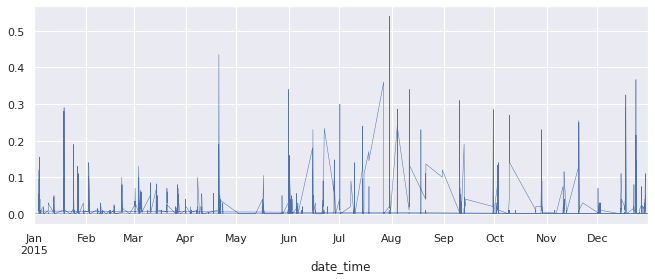

In [ ]:
df_weather_2015['precipitation'].plot(linewidth=0.5);

In [ ]:
df_weather_2015.groupby(by=[df_weather_2015.index.month]).describe()

In [ ]:
# Looking at the working days only and create a daily data set of working days:
snowy_days = df_weather_2015.groupby(by = [df_weather_2015.index.month, df_weather_2015.snow])['snow'].agg('count')
snowy_days

#df_weather_2015.groupby(by = df_weather_2015.index.month)['snow'].apply(lambda x: (x==True).sum()).reset_index(name='count')

In [ ]:
# Looking at the working days only and create a daily data set of working days:
rainy_days = df_weather_2015.groupby(by = [df_weather_2015.index.month, df_weather_2015.rain])['rain'].agg('count')
rainy_days

date_time  rain    
1          HEAVY         2
           LIGHT        31
           MODERATE      6
           NONE        704
2          LIGHT        13
           MODERATE      1
           NONE        657
3          HEAVY         1
           LIGHT        56
           MODERATE      3
           NONE        683
4          HEAVY         6
           LIGHT        26
           MODERATE      2
           NONE        686
5          HEAVY         3
           LIGHT        16
           NONE        725
6          HEAVY        13
           LIGHT        57
           MODERATE      5
           NONE        645
7          HEAVY         9
           LIGHT        14
           MODERATE      1
           NONE        720
8          HEAVY         7
           LIGHT         9
           NONE        728
9          HEAVY         6
           LIGHT        24
           MODERATE      3
           NONE        686
10         HEAVY         5
           LIGHT        36
           MODERATE      4
        

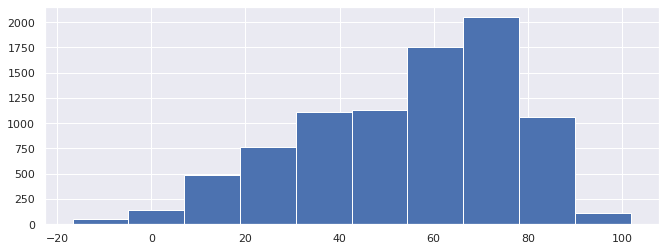

In [ ]:
df_weather_2015["feel_temperature"].hist()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


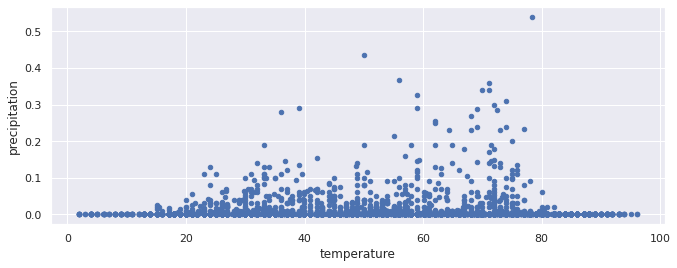

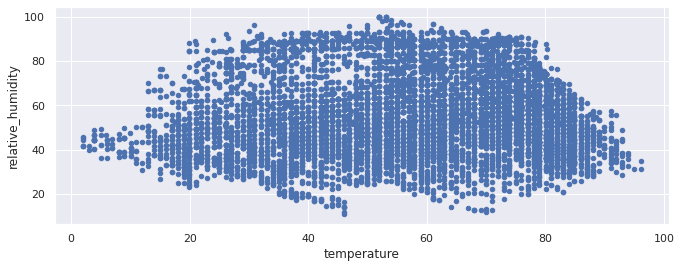

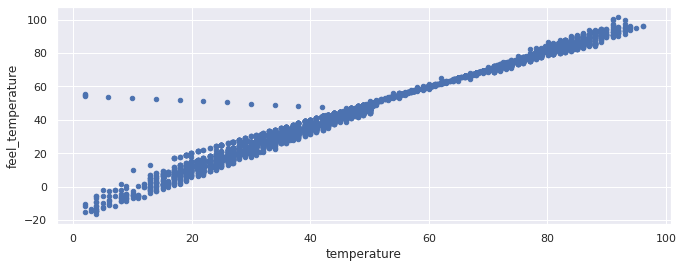

In [ ]:
df_weather_2015.plot.scatter(x='temperature', y='precipitation')
df_weather_2015.plot.scatter(x='temperature', y='relative_humidity')
df_weather_2015.plot.scatter(x='temperature', y='feel_temperature')

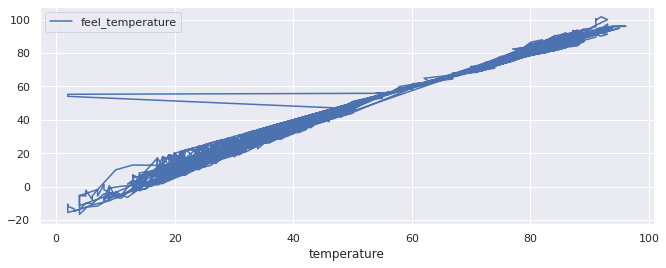

In [ ]:
weather_summary_plot = df_weather_2015.plot(x="temperature", y="feel_temperature")
#weather_summary_plot.set_xlabel("Month")
#weather_summary_plot.set_ylabel("Trip counts")

Examining collinearity across continuous variables

In [ ]:
correlation = df_weather_2015[['precipitation','temperature','relative_humidity','feel_temperature','dew_point', 'visibility']].corr(method = "pearson")
correlation.style.background_gradient(cmap='coolwarm')

,precipitation,temperature,relative_humidity,feel_temperature,dew_point,visibility
precipitation,1.000000,-0.018576,0.297266,-0.015555,0.089918,-0.468248
temperature,-0.018576,1.000000,0.061739,0.992598,0.903750,0.076289
relative_humidity,0.297266,0.061739,1.000000,0.083319,0.469344,-0.595827
feel_temperature,-0.015555,0.992598,0.083319,1.000000,0.911803,0.067246
dew_point,0.089918,0.903750,0.469344,0.911803,1.000000,-0.150867
visibility,-0.468248,0.076289,-0.595827,0.067246,-0.150867,1.000000


Using Spearman's Rank Correlation coefficient to evaluate collinearity across Categorical Features

In [ ]:
from scipy.stats import spearmanr

def spearman_comparison_categorical_features(feature_1, feature_2):
  coef, p = spearmanr(feature_1, feature_2)
  print('Spearmans correlation coefficient: %.3f' % coef)
  # interpreting the significance
  alpha = 0.05
  if p > alpha:
    print('Samples of ' +  feature_1.name + ' and ' + feature_2.name  +  ' are uncorrelated (fail to reject H0) p=%.3f' % p)
  else:
    print('Samples of ' +  feature_1.name + ' and ' + feature_2.name  +  ' are correlated (reject H0) p=%.3f' % p)

rain_data = df_weather_2015['rain']
mist_data = df_weather_2015['mist']
snow_data = df_weather_2015['snow']
haze_data = df_weather_2015['haze']

spearman_comparison_categorical_features(rain_data, mist_data)
spearman_comparison_categorical_features(rain_data,snow_data)
spearman_comparison_categorical_features(rain_data, haze_data)
spearman_comparison_categorical_features(mist_data, snow_data)
spearman_comparison_categorical_features(mist_data, haze_data)
spearman_comparison_categorical_features(haze_data, snow_data)


Using Contingency Tables to evaluate collinearity across Categorical Features

In [ ]:
df_weather_2015_events = df_weather_2015[['mist','rain','snow','haze']]
rain_data = df_weather_2015_events['rain']
mist_data = df_weather_2015_events['mist']
snow_data = df_weather_2015_events['snow']
haze_data = df_weather_2015_events['haze']
df_weather_2015_events.groupby([rain_data,mist_data, snow_data, haze_data]).count() 

Using CrossTab to obtain Contingency Tables for each weather event pair combination. 

In [ ]:
pd.crosstab(df_weather_2015.rain, df_weather_2015.mist)

In [ ]:
pd.crosstab(df_weather_2015.rain, df_weather_2015.snow)

In [ ]:
pd.crosstab(df_weather_2015.rain, df_weather_2015.haze)

In [ ]:
pd.crosstab(df_weather_2015.mist, df_weather_2015.haze)

In [ ]:
pd.crosstab(df_weather_2015.mist, df_weather_2015.snow)

In [ ]:
pd.crosstab(df_weather_2015.snow, df_weather_2015.haze)

### One-hot encoding Weather Events
Applying one-hot encoding to categorical features (snow, mist, haze, rain, unknown precipitation) to obtain dichotomous features that can be evaluated using Point-Biserial Correlation (special case of Pearson's Correlation) 

In [ ]:
df_weather_2015_encoded = pd.get_dummies(df_weather_2015, prefix=None, dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
df_weather_2015_encoded

Evaluating collinearity between dichotomous features

(However, now that one-hot-enconding proliferated binary features, it might be difficult to observe)

In [ ]:
correlation = df_weather_2015_encoded[['mist_NONE', 'mist_MODERATE',
                                       'snow_NONE', 'snow_LIGHT', 'snow_MODERATE', 'snow_HEAVY',
                                       'rain_NONE', 'rain_LIGHT', 'rain_MODERATE', 'rain_HEAVY',
                                       'haze_NONE','haze_MODERATE'
                                       ]].corr(method = "pearson")
correlation.style.background_gradient(cmap='coolwarm')

Evaluating correlation between Binary and Continuous features using Point-Biserial Correlation

In [ ]:
from scipy import stats

def point_biserial_correlation(bool_feature, continuous_feature):
  coef, p = stats.pointbiserialr(bool_feature, continuous_feature)
  print('Point-Biserial correlation coefficient: %.3f' % coef)
  # interpreting the significance
  alpha = 0.05
  if p > alpha:
    print('Samples of ' +  bool_feature.name + ' and ' + continuous_feature.name  +  ' are uncorrelated (fail to reject H0) p=%.3f' % p)
  else:
    print('Samples of ' +  bool_feature.name + ' and ' + continuous_feature.name  +  ' are correlated (reject H0) p=%.3f' % p)


mist_NONE = df_weather_2015_encoded['mist_NONE']
mist_MODERATE = df_weather_2015_encoded['mist_MODERATE']
snow_NONE = df_weather_2015_encoded['snow_NONE']
snow_LIGHT = df_weather_2015_encoded['snow_LIGHT']
snow_MODERATE = df_weather_2015_encoded['snow_MODERATE']
snow_HEAVY = df_weather_2015_encoded['snow_HEAVY']
rain_NONE = df_weather_2015_encoded['rain_NONE']
rain_LIGHT = df_weather_2015_encoded['rain_LIGHT']
rain_MODERATE = df_weather_2015_encoded['rain_MODERATE']
haze_NONE = df_weather_2015_encoded['haze_NONE']
haze_MODERATE = df_weather_2015_encoded['haze_MODERATE']
temperature = df_weather_2015_encoded['temperature']
relative_humidity = df_weather_2015_encoded['relative_humidity']
precipitation = df_weather_2015_encoded['precipitation']
visibility = df_weather_2015_encoded['visibility']

point_biserial_correlation(mist_NONE, temperature)
point_biserial_correlation(mist_MODERATE, temperature)
point_biserial_correlation(snow_NONE, temperature)
point_biserial_correlation(snow_LIGHT, temperature)
point_biserial_correlation(snow_MODERATE, temperature)
point_biserial_correlation(snow_HEAVY, temperature)

Evaluating correlation between dichotomous and continuous features using Peason's Correlation

In [ ]:
correlation = df_weather_2015_encoded[['feel_temperature',
                                       'relative_humidity',
                                       'precipitation',
                                       #'visibility',
                                       #'mist_NONE', 'mist_MODERATE',
                                       'snow_NONE', 'snow_LIGHT', 'snow_MODERATE', 'snow_HEAVY',
                                       'rain_NONE', 'rain_LIGHT', 'rain_MODERATE', 'rain_HEAVY',
                                       'haze_NONE','haze_MODERATE',
                                       ]].corr(method = "pearson")
correlation.style.background_gradient(cmap='coolwarm')

In [ ]:
correlation = df_weather_2015_encoded.corr(method = "pearson")
correlation.style.background_gradient(cmap='coolwarm')

In [ ]:
formula_str="temperature~precipitation"
result_temperature_precipitation = sm.ols(formula=formula_str,data=df_weather_2015).fit()
print(result_temperature_precipitation.summary())

In [ ]:
formula_str="temperature~rain"
result_temperature_precipitation = sm.ols(formula=formula_str,data=df_weather_2015).fit()
print(result_temperature_precipitation.summary())

In [ ]:
formula_str="temperature~haze"
result_temperature_precipitation = sm.ols(formula=formula_str,data=df_weather_2015).fit()
print(result_temperature_precipitation.summary())

# Green tax trips dataset x weather data

## Merging Taxi data with Binary Weather data

In [ ]:
df_trip_weather_encoded = pd.merge(df_green_tripdata_2015_agg_per_hour, df_weather_2015_encoded.reset_index(), left_on='lpep_pickup_datetime', right_on='date_time')
df_trip_weather_encoded.drop(['lpep_pickup_datetime'], axis=1, inplace=True)
df_trip_weather_encoded.set_index('date_time', inplace = True)
df_trip_weather_encoded

,Fare_amount_count,Fare_amount_sum,Tip_amount_count,Tip_amount_sum,temperature,dew_point,relative_humidity,precipitation,visibility,feel_temperature,rain_HEAVY,rain_LIGHT,rain_MODERATE,rain_NONE,mist_MODERATE,mist_NONE,snow_HEAVY,snow_LIGHT,snow_MODERATE,snow_NONE,haze_MODERATE,haze_NONE,unknown_precipitation_MODERATE,unknown_precipitation_NONE
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00,625,7931.50,625,647.52,30.02,6.98,37.17,0.0,10.0,25.110,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-01 01:00,676,8987.00,676,679.02,30.02,6.08,35.68,0.0,10.0,26.430,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-01 02:00,631,8982.50,631,726.00,30.02,8.06,39.03,0.0,10.0,25.110,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-01 03:00,611,7931.01,611,641.07,28.94,8.96,41.55,0.0,10.0,23.955,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-01 04:00,568,7193.50,568,531.70,28.04,8.96,44.07,0.0,10.0,22.800,0,0,0,1,0,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-30 19:00,325,3636.00,325,344.58,44.06,39.02,82.31,0.0,5.0,39.480,0,0,0,1,0,1,0,0,0,1,1,0,0,1
2015-12-30 20:00,281,2950.50,281,314.01,44.06,39.92,85.25,0.0,4.0,40.050,0,0,0,1,1,0,0,0,0,1,0,1,0,1
2015-12-30 21:00,265,2816.29,265,305.15,44.96,39.92,82.38,0.0,7.0,42.550,0,0,0,1,0,1,0,0,0,1,0,1,0,1


Merging Taxi data with Weather Ordinal Data

In [ ]:
df_trip_weather = pd.merge(df_green_tripdata_2015_agg_per_hour, df_weather_2015.reset_index(), left_on='lpep_pickup_datetime', right_on='date_time')
df_trip_weather.drop(['lpep_pickup_datetime'], axis=1, inplace=True)
df_trip_weather.set_index('date_time', inplace = True)
df_trip_weather

,Fare_amount_count,Fare_amount_sum,Tip_amount_count,Tip_amount_sum,rain,mist,snow,haze,unknown_precipitation,temperature,dew_point,relative_humidity,precipitation,visibility,feel_temperature
date_time,,,,,,,,,,,,,,,
2015-01-01 00:00,625,7931.50,625,647.52,NONE,NONE,NONE,NONE,NONE,30.02,6.98,37.17,0.0,10.0,25.110
2015-01-01 01:00,676,8987.00,676,679.02,NONE,NONE,NONE,NONE,NONE,30.02,6.08,35.68,0.0,10.0,26.430
2015-01-01 02:00,631,8982.50,631,726.00,NONE,NONE,NONE,NONE,NONE,30.02,8.06,39.03,0.0,10.0,25.110
2015-01-01 03:00,611,7931.01,611,641.07,NONE,NONE,NONE,NONE,NONE,28.94,8.96,41.55,0.0,10.0,23.955
2015-01-01 04:00,568,7193.50,568,531.70,NONE,NONE,NONE,NONE,NONE,28.04,8.96,44.07,0.0,10.0,22.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-30 19:00,325,3636.00,325,344.58,NONE,NONE,NONE,MODERATE,NONE,44.06,39.02,82.31,0.0,5.0,39.480
2015-12-30 20:00,281,2950.50,281,314.01,NONE,MODERATE,NONE,NONE,NONE,44.06,39.92,85.25,0.0,4.0,40.050
2015-12-30 21:00,265,2816.29,265,305.15,NONE,NONE,NONE,NONE,NONE,44.96,39.92,82.38,0.0,7.0,42.550


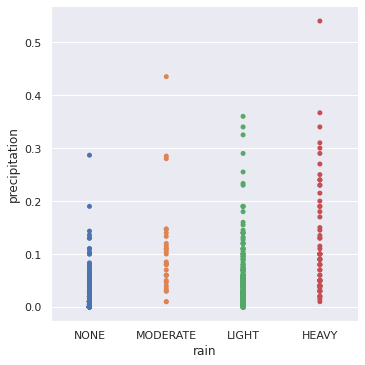

In [ ]:
sns.catplot(x="rain", y="precipitation", jitter=False, data=df_trip_weather)

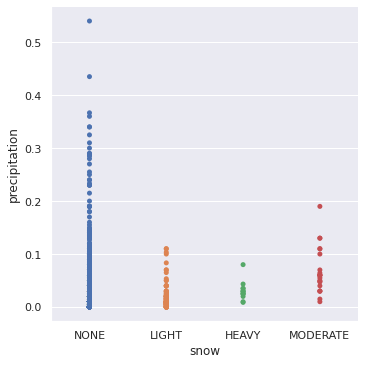

In [ ]:
sns.catplot(x="snow", y="precipitation", jitter=False, data=df_trip_weather)

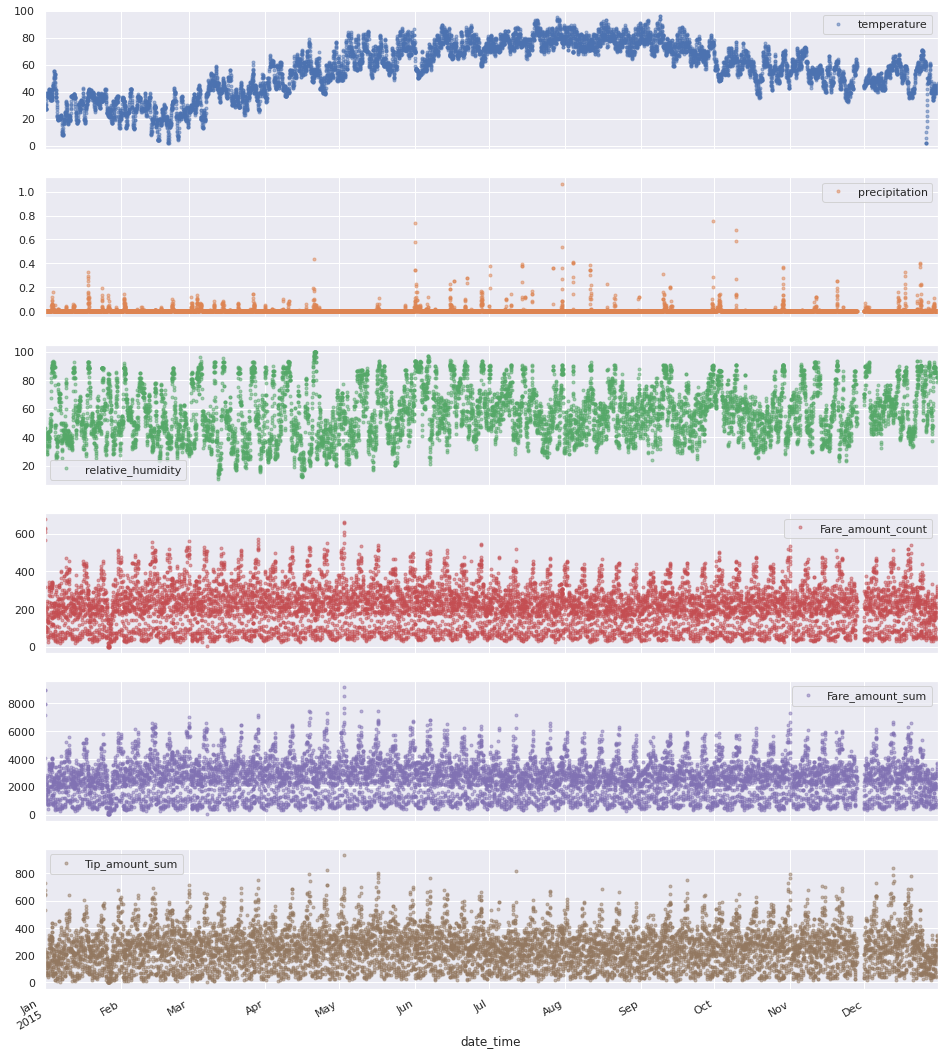

In [ ]:
sns.set(rc={'figure.figsize':(16, 10)})

columns_plot = ['temperature', 'precipitation', 'relative_humidity', 'Fare_amount_count', 'Fare_amount_sum', 'Tip_amount_sum']
axes = df_trip_weather[columns_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(16, 20), subplots=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

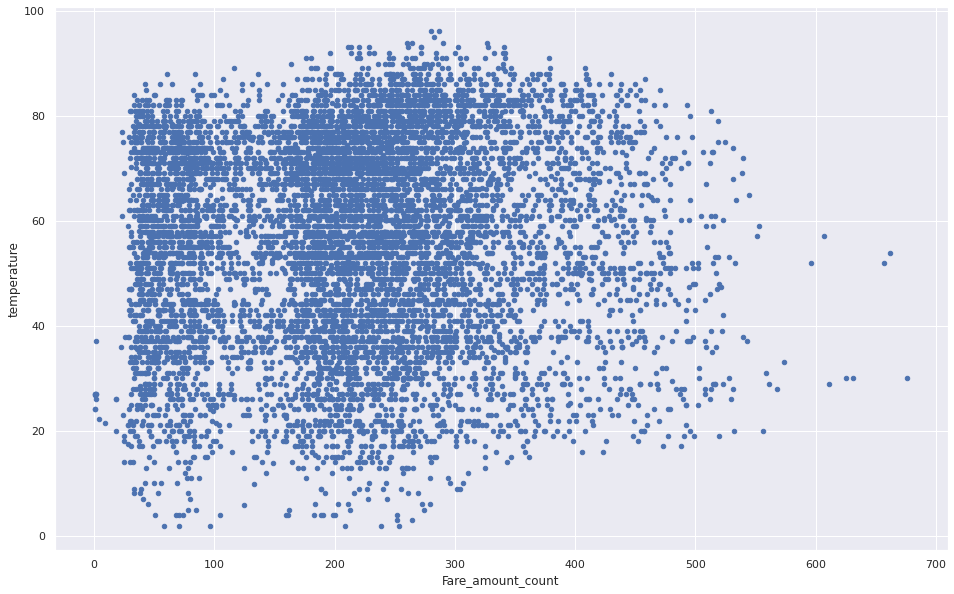

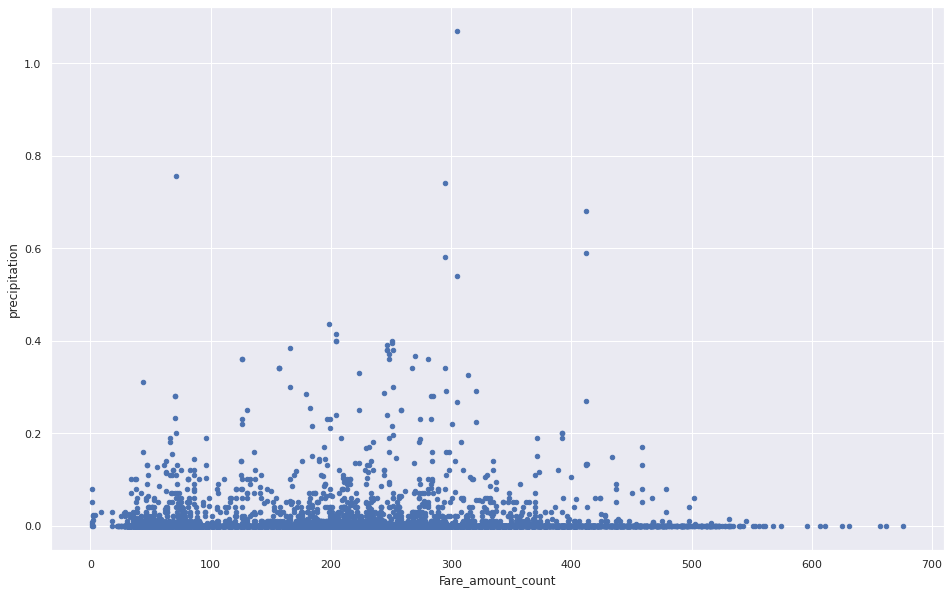

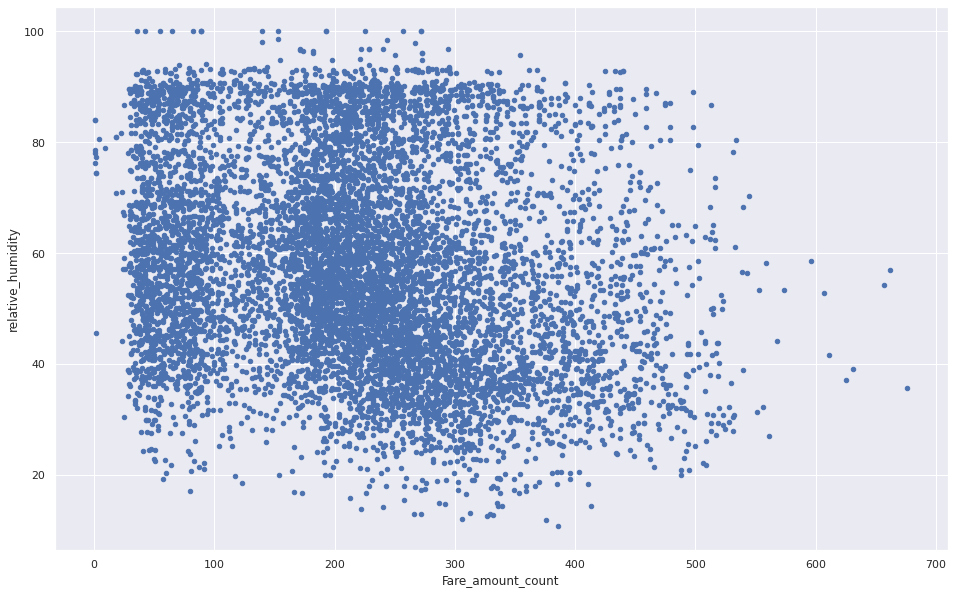

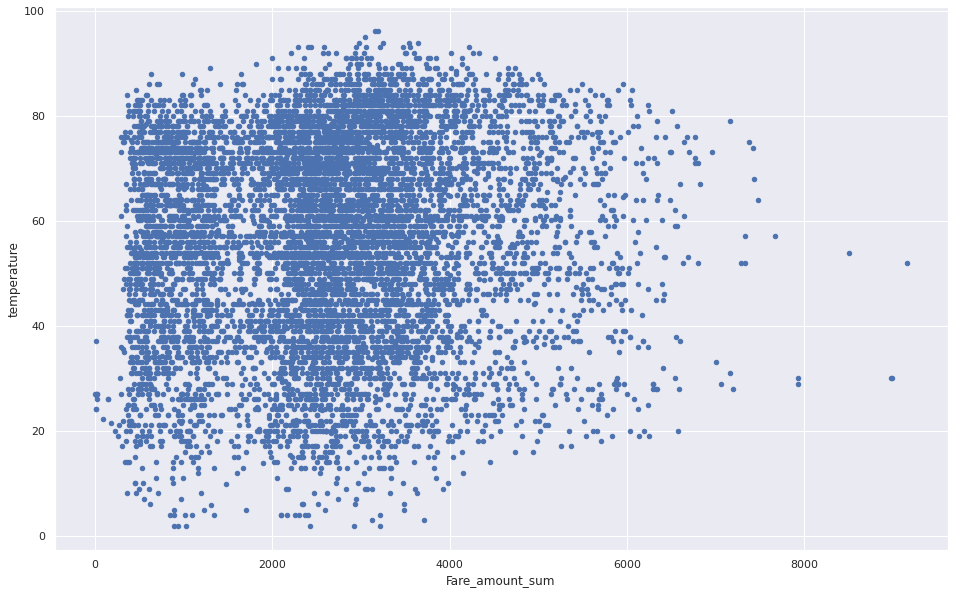

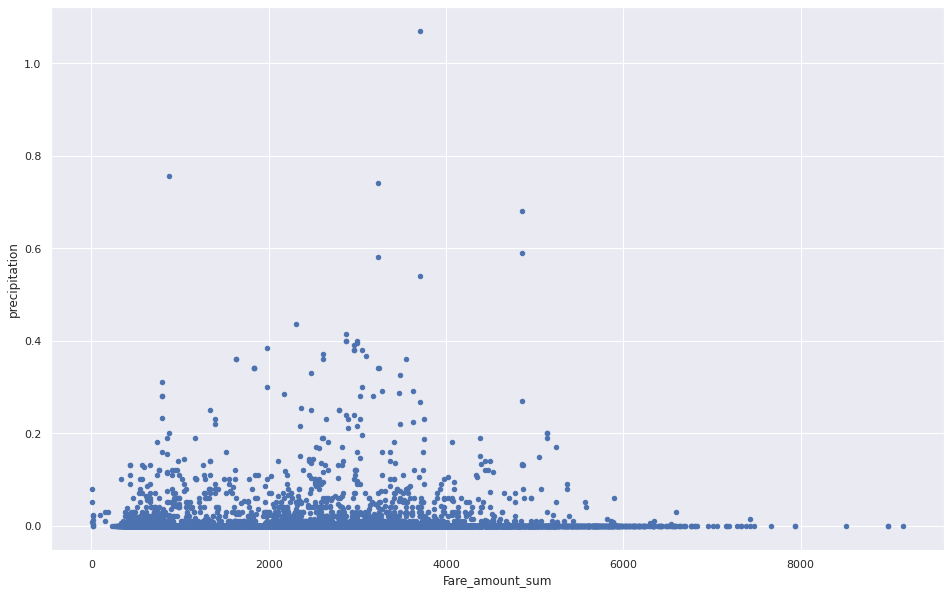

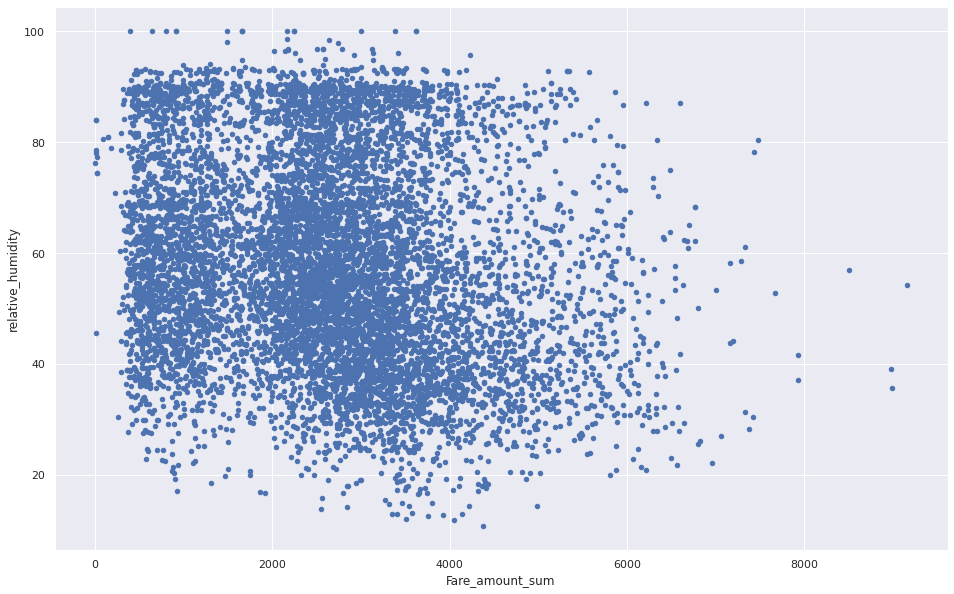

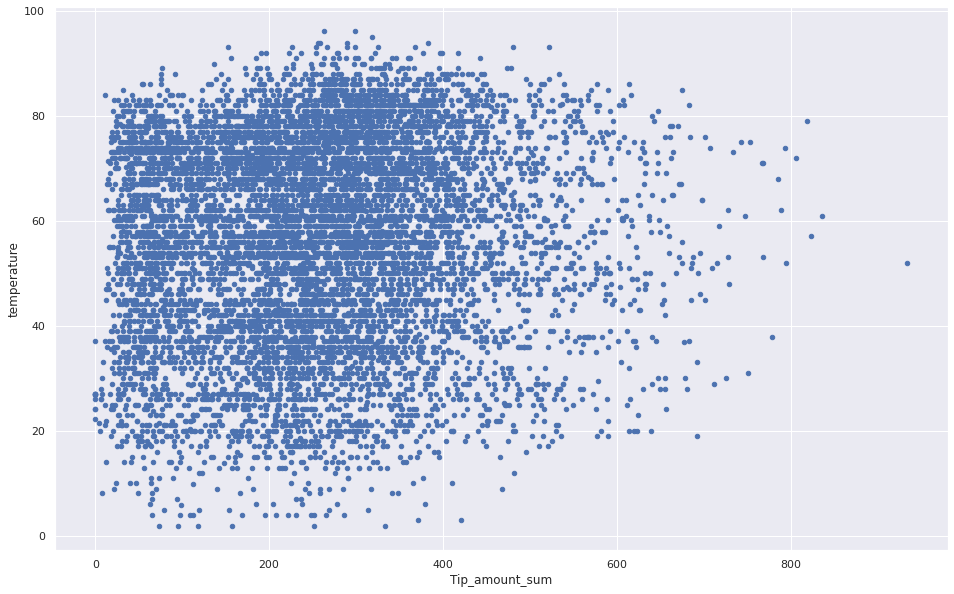

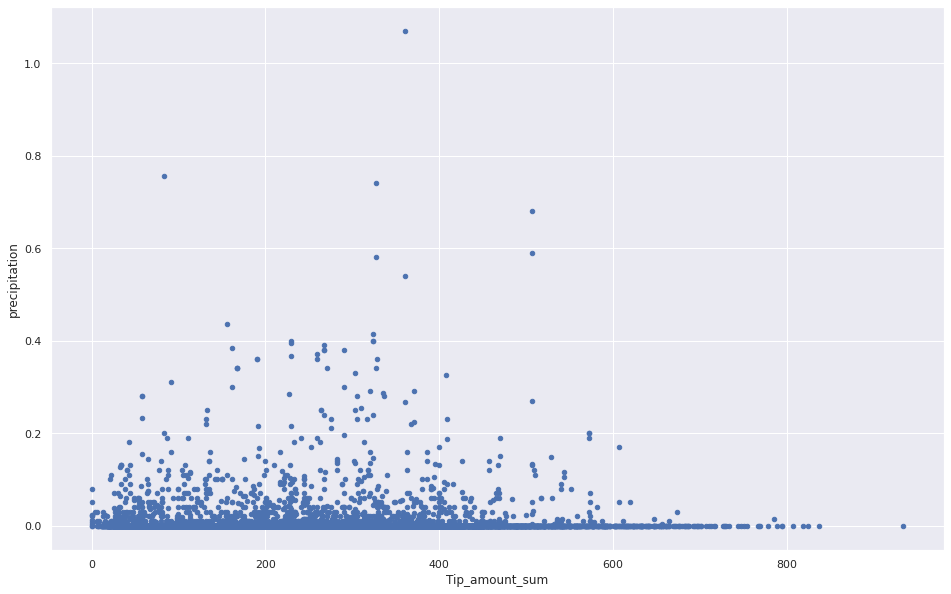

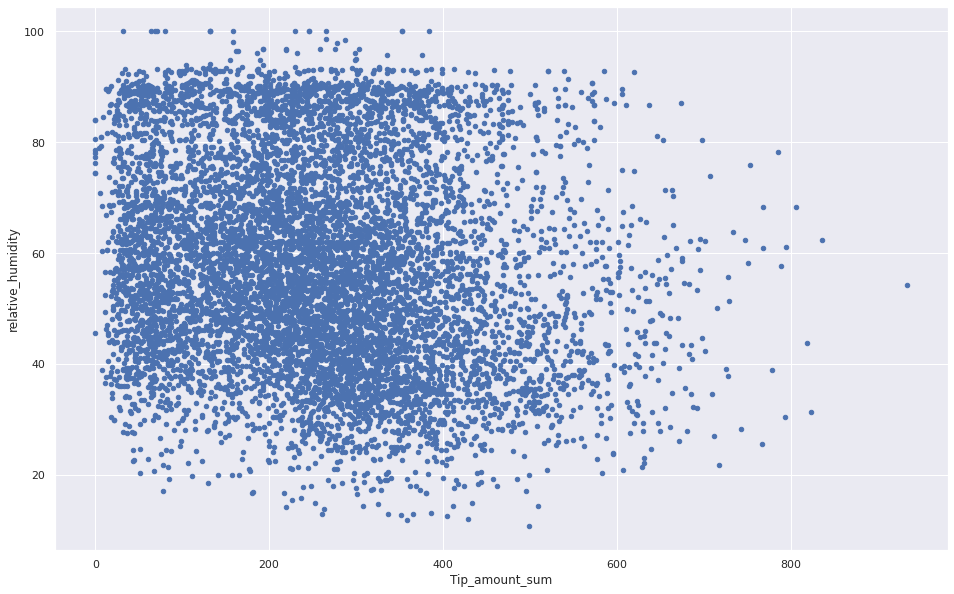

In [ ]:
df_trip_weather.plot.scatter(x='Fare_amount_count', y='temperature')
df_trip_weather.plot.scatter(x='Fare_amount_count', y='precipitation')
df_trip_weather.plot.scatter(x='Fare_amount_count', y='relative_humidity')
df_trip_weather.plot.scatter(x='Fare_amount_sum', y='temperature')
df_trip_weather.plot.scatter(x='Fare_amount_sum', y='precipitation')
df_trip_weather.plot.scatter(x='Fare_amount_sum', y='relative_humidity')
df_trip_weather.plot.scatter(x='Tip_amount_sum', y='temperature')
df_trip_weather.plot.scatter(x='Tip_amount_sum', y='precipitation')
df_trip_weather.plot.scatter(x='Tip_amount_sum', y='relative_humidity')

In [ ]:
corr = df_trip_weather[['precipitation', 'relative_humidity', 'feel_temperature', 'snow', 'haze', 'rain', 'Fare_amount_count']].corr()
corr.style.background_gradient(cmap='coolwarm')

,precipitation,relative_humidity,feel_temperature,Fare_amount_count
precipitation,1.000000,0.296973,-0.014231,-0.006120
relative_humidity,0.296973,1.000000,0.084175,-0.226375
feel_temperature,-0.014231,0.084175,1.000000,0.039441
Fare_amount_count,-0.006120,-0.226375,0.039441,1.000000


In [ ]:
corr = df_trip_weather[['precipitation', 'relative_humidity', 'feel_temperature', 'snow', 'haze', 'rain', 'Fare_amount_sum']].corr()
corr.style.background_gradient(cmap='coolwarm')

,precipitation,relative_humidity,feel_temperature,Fare_amount_sum
precipitation,1.000000,0.296973,-0.014231,-0.013399
relative_humidity,0.296973,1.000000,0.084175,-0.213878
feel_temperature,-0.014231,0.084175,1.000000,0.064375
Fare_amount_sum,-0.013399,-0.213878,0.064375,1.000000


In [ ]:
corr = df_trip_weather[['precipitation', 'relative_humidity', 'feel_temperature', 'snow', 'haze', 'rain', 'Tip_amount_sum']].corr()
corr.style.background_gradient(cmap='coolwarm')

,precipitation,relative_humidity,feel_temperature,Tip_amount_sum
precipitation,1.000000,0.296973,-0.014231,-0.006238
relative_humidity,0.296973,1.000000,0.084175,-0.177141
feel_temperature,-0.014231,0.084175,1.000000,0.065509
Tip_amount_sum,-0.006238,-0.177141,0.065509,1.000000


## OLS (Ordinary least square)

Modelling using X = feel_temperature + precipitation + relative_humidity

In [ ]:
df_trip_weather['precipitation'].isnull().values.any()

False

In [ ]:
df_trip_weather["log_feel_temperature"] = np.log(df_trip_weather["feel_temperature"])
df_trip_weather["log_precipitation"] = np.log(df_trip_weather["precipitation"])
df_trip_weather["log_relative_humidity"] = np.log(df_trip_weather["relative_humidity"])



formula_str="Fare_amount_sum~relative_humidity+feel_temperature+rain+snow+haze"
result_fare_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_fare_amount_sum_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:        Fare_amount_sum   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     71.23
Date:                Mon, 05 Apr 2021   Prob (F-statistic):          2.01e-127
Time:                        19:31:54   Log-Likelihood:                -74284.
No. Observations:                8660   AIC:                         1.486e+05
Df Residuals:                    8650   BIC:                         1.487e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5701.4190    414.93

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
formula_str="Fare_amount_count~relative_humidity+feel_temperature+rain+snow+haze"
result_fare_amount_count_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_fare_amount_count_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:      Fare_amount_count   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     79.03
Date:                Mon, 05 Apr 2021   Prob (F-statistic):          2.11e-141
Time:                        19:27:41   Log-Likelihood:                -52689.
No. Observations:                8660   AIC:                         1.054e+05
Df Residuals:                    8650   BIC:                         1.055e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           504.6678     34.27

In [ ]:
formula_str="Tip_amount_sum~relative_humidity+feel_temperature+rain+snow+haze"
result_tip_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_tip_amount_sum_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:         Tip_amount_sum   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     50.81
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           2.31e-90
Time:                        19:32:20   Log-Likelihood:                -54862.
No. Observations:                8660   AIC:                         1.097e+05
Df Residuals:                    8650   BIC:                         1.098e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           525.9133     44.05

Modelling using Xs = feel temperature +  weather features




In [ ]:
formula_str="Fare_amount_count~rain"

result_fare_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_fare_amount_sum_weather_features.summary())
df_trip_weather.loc[df_trip_weather.rain =="HEAVY"]

                            OLS Regression Results                            
Dep. Variable:      Fare_amount_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.800
Date:                Mon, 05 Apr 2021   Prob (F-statistic):             0.0385
Time:                        17:43:33   Log-Likelihood:                -53027.
No. Observations:                8660   AIC:                         1.061e+05
Df Residuals:                    8656   BIC:                         1.061e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          221.4844     13.805  

,Fare_amount_count,Fare_amount_sum,Tip_amount_count,Tip_amount_sum,rain,mist,snow,haze,unknown_precipitation,temperature,dew_point,relative_humidity,precipitation,visibility,feel_temperature
date_time,,,,,,,,,,,,,,,
2015-01-18 19:00,296,3276.00,296,319.74,HEAVY,MODERATE,NONE,NONE,NONE,39.02,37.04,92.530,0.290000,0.250000,36.710
2015-01-18 20:00,223,2474.51,223,302.58,HEAVY,MODERATE,NONE,NONE,NONE,39.02,36.50,90.595,0.135000,0.250000,37.865
2015-03-27 02:00,125,1342.50,125,135.42,HEAVY,MODERATE,NONE,NONE,NONE,50.00,48.02,92.870,0.080000,1.250000,46.720
2015-04-10 08:00,252,3407.80,252,399.40,HEAVY,MODERATE,NONE,NONE,NONE,39.92,37.04,89.340,0.030000,1.750000,35.800
2015-04-20 12:00,213,2594.00,213,228.73,HEAVY,MODERATE,NONE,NONE,NONE,51.08,48.02,89.220,0.090000,1.250000,51.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-23 20:00,318,3416.50,318,291.58,HEAVY,MODERATE,NONE,NONE,NONE,55.94,53.06,90.030,0.100000,1.000000,55.940
2015-12-23 21:00,270,3097.50,270,228.82,HEAVY,MODERATE,NONE,NONE,NONE,55.94,53.06,90.030,0.366667,1.333333,55.940
2015-12-23 22:00,251,2994.00,251,229.77,HEAVY,MODERATE,NONE,NONE,NONE,55.04,51.98,89.400,0.215000,1.000000,55.040


In [ ]:
formula_str="Fare_amount_sum~rain+snow+haze"
result_fare_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_fare_amount_sum_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:        Fare_amount_sum   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.612
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           0.000769
Time:                        15:53:25   Log-Likelihood:                -74585.
No. Observations:                8660   AIC:                         1.492e+05
Df Residuals:                    8656   BIC:                         1.492e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2650.1567     14.957    177.185      0.0

In [ ]:
formula_str="Tip_amount_sum~rain+snow"
result_fare_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather).fit()
print(result_fare_amount_sum_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:         Tip_amount_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.452
Date:                Mon, 05 Apr 2021   Prob (F-statistic):              0.234
Time:                        15:53:30   Log-Likelihood:                -55084.
No. Observations:                8660   AIC:                         1.102e+05
Df Residuals:                    8657   BIC:                         1.102e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    256.0650      1.547    165.561      0.0

Modelling using Xs = feel temperature + binary weather features




In [ ]:
formula_str="Fare_amount_count~feel_temperature+relative_humidity+rain_LIGHT+rain_MODERATE+rain_HEAVY"
result_fare_amount_sum_weather_features = sm.ols(formula=formula_str,data=df_trip_weather_encoded).fit()
print(result_fare_amount_sum_weather_features.summary())

                            OLS Regression Results                            
Dep. Variable:      Fare_amount_count   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     118.6
Date:                Mon, 05 Apr 2021   Prob (F-statistic):          9.68e-122
Time:                        19:26:26   Log-Likelihood:                -52744.
No. Observations:                8660   AIC:                         1.055e+05
Df Residuals:                    8654   BIC:                         1.055e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           293.8098      4.73

In [ ]:
a = df_trip_weather_encoded["Fare_amount_count"]
b = df_trip_weather_encoded["rain_LIGHT"]
spearman_comparison_categorical_features(a,b)

df_trip_weather_encoded.loc[(df_trip_weather_encoded.index.day == 3) & (df_trip_weather_encoded.index.month == 1)]

Spearmans correlation coefficient: -0.008
Samples of Fare_amount_count and rain_LIGHT are uncorrelated (fail to reject H0) p=0.483


,Fare_amount_count,Fare_amount_sum,Tip_amount_count,Tip_amount_sum,temperature,dew_point,relative_humidity,precipitation,visibility,feel_temperature,rain_HEAVY,rain_LIGHT,rain_MODERATE,rain_NONE,mist_MODERATE,mist_NONE,snow_HEAVY,snow_LIGHT,snow_MODERATE,snow_NONE,haze_MODERATE,haze_NONE,unknown_precipitation_MODERATE,unknown_precipitation_NONE
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-03 00:00,318,3419.50,318,316.85,37.94,17.96,44.0000,0.0000,10.000,33.450,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 01:00,270,2929.00,270,272.58,37.94,17.96,44.0000,0.0000,10.000,34.360,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 02:00,215,2474.00,215,218.03,37.04,17.96,45.5800,0.0000,10.000,33.310,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 03:00,169,1985.00,169,166.46,35.96,19.04,49.8300,0.0000,10.000,33.220,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 04:00,132,1684.50,132,133.42,35.06,19.94,53.6600,0.0000,10.000,30.990,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 05:00,63,939.01,63,59.35,35.06,17.96,49.3000,0.0000,10.000,29.220,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 06:00,53,785.05,53,51.72,33.98,17.96,51.4700,0.0000,10.000,33.980,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 07:00,64,831.00,64,86.08,35.06,15.98,45.2600,0.0000,10.000,30.030,0,0,0,1,0,1,0,0,0,1,0,1,0,1
2015-01-03 08:00,79,1152.00,79,102.02,35.06,17.06,47.4200,0.0000,10.000,29.220,0,0,0,1,0,1,0,0,0,1,0,1,0,1


## GLMs (Generalized Linear Models)

1st step: let's validate if we can use a linear model by checking if the Y (total_amount) meets the following criteria:

1. Total_amount values are independent (Y1 independent from Y2, from Y3, etc.)
2. Total_amount is a normal distribution 
3. Mean of Total_Amount is related to predictors by a linear model 


To go ahead with GLMs, we want to focus on the 2nd condition: Total_Amount might come from any exponential family distribution; and 3rd condition: some function of the Mean relateds to a linear predictor.

Linear Models use OLS or Maximum Likelihood whereas GLMs only use the latter. OLS is indeed a special case of Maximum Likelihood. 


## GAMs (Generalized Additive Models)

GAMs provide a middle-ground between simple models like linear regression and more advanced models (neural networks). 

Linear models are easier to interpret but might be limited in modeling reality. Machine learning models are very good at predictions but require lots of data and are different to interpret.

The main difference is that while "classical" forms of linear, or generalized linear, models assume a fixed linear or some other parametric form of the relationship between the dependent variable and the covariates, GAM do not assume a priori any specific form of this relationship, and can be used to reveal and estimate non-linear effects of the covariate on the dependent variable. More in detail, while in (generalized) linear models the linear predictor is a weighted sum of the n covariates, ∑ni=1βixi, in GAMs this term is replaced by a sum of "smooth functions", e.g. ∑ni=1∑qj=1βisj(xi), where the s1(⋅),…,sq(⋅) are smooth "basis functions" (e.g. cubic splines) and q is the basis dimension. By combining the basis functions GAMs can represent a large number of functional relationship (to do so they rely on the assumption that the true relationship is likely to be smooth, rather than wiggly). They are essentially an extension of GLMs, however they are designed in a way that makes them particularly useful for uncovering nonlinear effects of numerical covariates, and for doing so in an "automatic" fashion (from Hastie and Tibshirani original article, they have 'the advantage of being completely automatic, i.e. no "detective" work is needed on the part of the statistician').

Because we are trying to calculate a the "fare amount", we need to use a linear GAM, which has the following form: 

    E[y|X]=β0+f1(X1)+f2(X2,X3)+⋯+fM(XN)

This is the GAM we will implement to predict the fare_amount depending on the following: 
    
    PredictedFare = intercept + f1(temperature) + f2(rain) + f3(snow) + f4(precipitation) + f5(humidity) + f6(precipitation, rain) + f7(precipitation, snow) + f8(humidity, rain) + f9(temperature, snow)**

We will be implementing this as follows:

knots ← list(df_trip_weather.date_time)

predictect_trips_df ← gam(fare_amount ~
  s(temperature, K = 100) +
  s(rain, K= 10) +
  s(snow, K = 10) + 
  s(precipitation, k=100, bs = 'ds') +
  s(humidity, k=100, bs = 'ds') +
  ti(precipitation, rain, d = c(1,1), k = c(100,10), bs = c('ds','tp')) 
  ti(precipitation, snow, d = c(1,1), k = c(100,10), bs = c('ds','tp')) 
  ti(humidity, rain, d = c(1,1), k = c(100,10), bs = c('ds','tp'))
  ti(temperature, snow, d = c(1,1), k = c(100,10), bs = c('tp','tp')), 
  data = df_trip_weather, knots = knots, method = 'fREML')

* We will use smooth functions for each of the main features
* We will use tensor product smooths for the combinations of some of the features, which might have impact on the use of taxis and the fare
* We may try using an isotropic thin plate spline, making the smoothness of more than one feature go in the same direction
* We will use fast REML, given the amount of data we have to process. We may also use "BAM" instead of "GAM" to allow for more data processing.

In [ ]:
!pip install pygam
from pygam import LinearGAM, s, f

     |████████████████████████████████| 1.8MB 4.5MB/s 


In [ ]:
X = df_trip_weather[['temperature','precipitation', 'relative_humidity']].to_numpy()
y = df_trip_weather.Fare_amount_sum.tolist()

#To-do: remove NAN's from dataframe, otherwise you will get error "SVD did not converge". Now, removing NANs in this dataframe is tricky. Think about how to do this 
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)

## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['Temperature', 'Precipitation', 'Relative Humidity']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

 54% (6 of 11) |#############            | Elapsed Time: 0:16:24 ETA:   0:13:34

LinAlgError: ignored

In [ ]:
predictect_trips_df ← gam(fare_amount ~
  s(temperature, K = 100) +
  s(rain, K= 10) +
  s(snow, K = 10) + 
  s(precipitation, k=100, bs = 'ds') +
  s(humidity, k=100, bs = 'ds') +
  ti(precipitation, rain, d = c(1,1), k = c(100,10), bs = c('ds','tp')) 
  ti(precipitation, snow, d = c(1,1), k = c(100,10), bs = c('ds','tp')) 
  ti(humidity, rain, d = c(1,1), k = c(100,10), bs = c('ds','tp'))
  ti(temperature, snow, d = c(1,1), k = c(100,10), bs = c('tp','tp')), 
  data = df_trip_weather, knots = knots, method = 'fREML')